# Look at "good" and "bad" reps performed as examples.

In [2]:
import pandas as pd
import numpy as np

import scipy.signal as scisig
from scipy.stats import norm
from scipy.signal import butter, sosfreqz, sosfiltfilt, boxcar, savgol_filter, find_peaks
from scipy.signal.signaltools import hilbert


# module_path = os.path.abspath(os.path.join('../utils'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

import matplotlib.pyplot as plt
import seaborn as sns
    
import ipynb.fs.full.Data_utils as data_utils
import ipynb.fs.full.Plotting_utils as plot_utils

from IPython.display import set_matplotlib_formats

In [3]:
# Set the default figure sizes.
#
plt.rc('figure', figsize=(15, 7))
sns.set(rc={'figure.figsize':(15,7)})

# Set figures to high resolution (2x)
set_matplotlib_formats('retina')

#### Begin data processing

In [4]:
data_path = "./../data/Train"
data_df = data_utils.load_participant_data_from_path(data_path, debug=False)
print("Indices names for multi-index df: ", data_df.index.names)
# data_df

Reading in data from:  ./../data/Train/valerio_good0142.tsv
Reading in data from:  ./../data/Train/valerio_bad0144.tsv
Reading in data from:  ./../data/Train/jacob_bad0140.tsv
Reading in data from:  ./../data/Train/jacob_good0092.tsv
Indices names for multi-index df:  ['participant', 'type', 'point-perf.', 'time']


In [5]:
# Group the data based on various interests. 
# Let's separate the data into each participants 'good' and 'bad' movements.
#
# df = data_df.xs(['jacob', 'good', 'combined']) # slicing.

# Group data by 'type', which is 'good', or 'bad' repititions.
#
group_type = data_df.groupby('type')

In [6]:
# Separate out the good and bad for our known repitions (i.e. asked to perform good or bad repititions).
#
spine_dist_good_df = data_utils.form_spine_distance(group_type.get_group('good'))
spine_dist_bad_df = data_utils.form_spine_distance(group_type.get_group('bad'))


### Look at the good repititions for Valerio

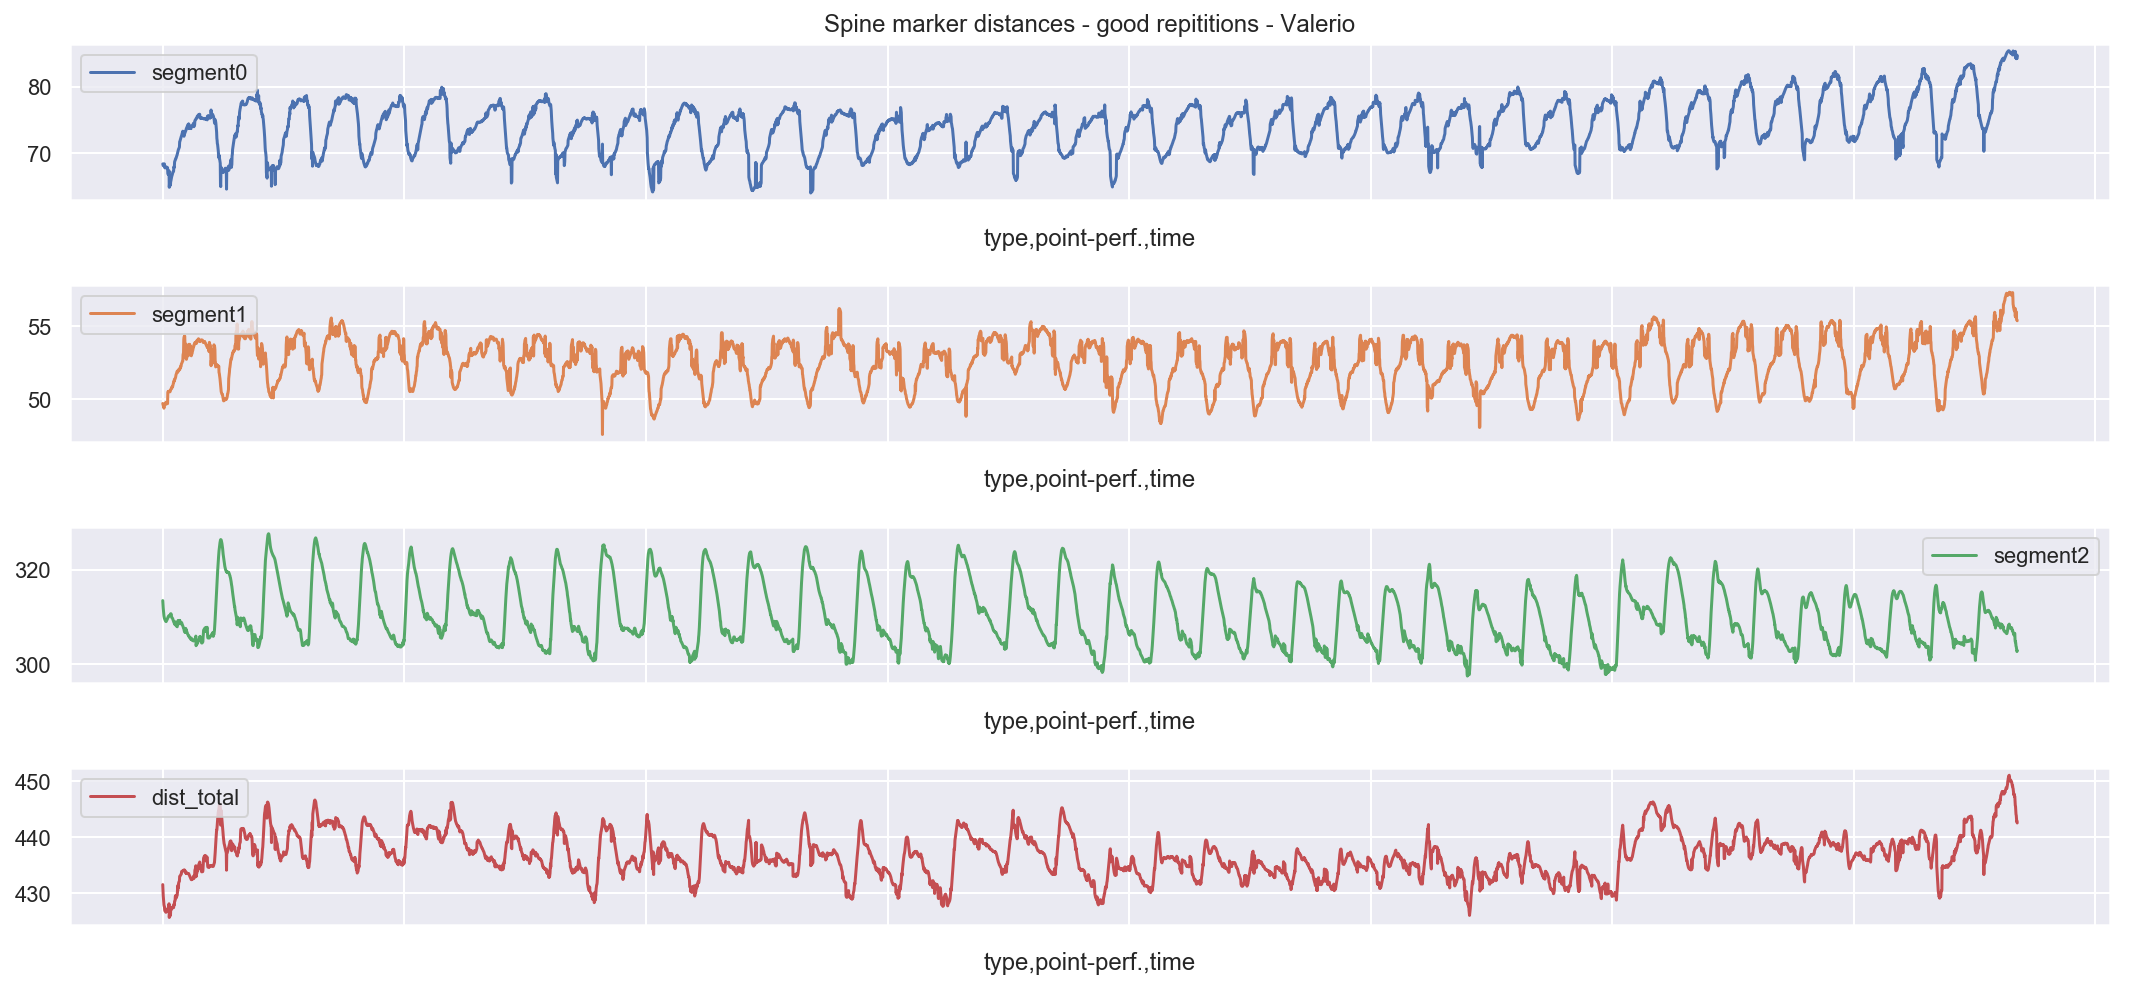

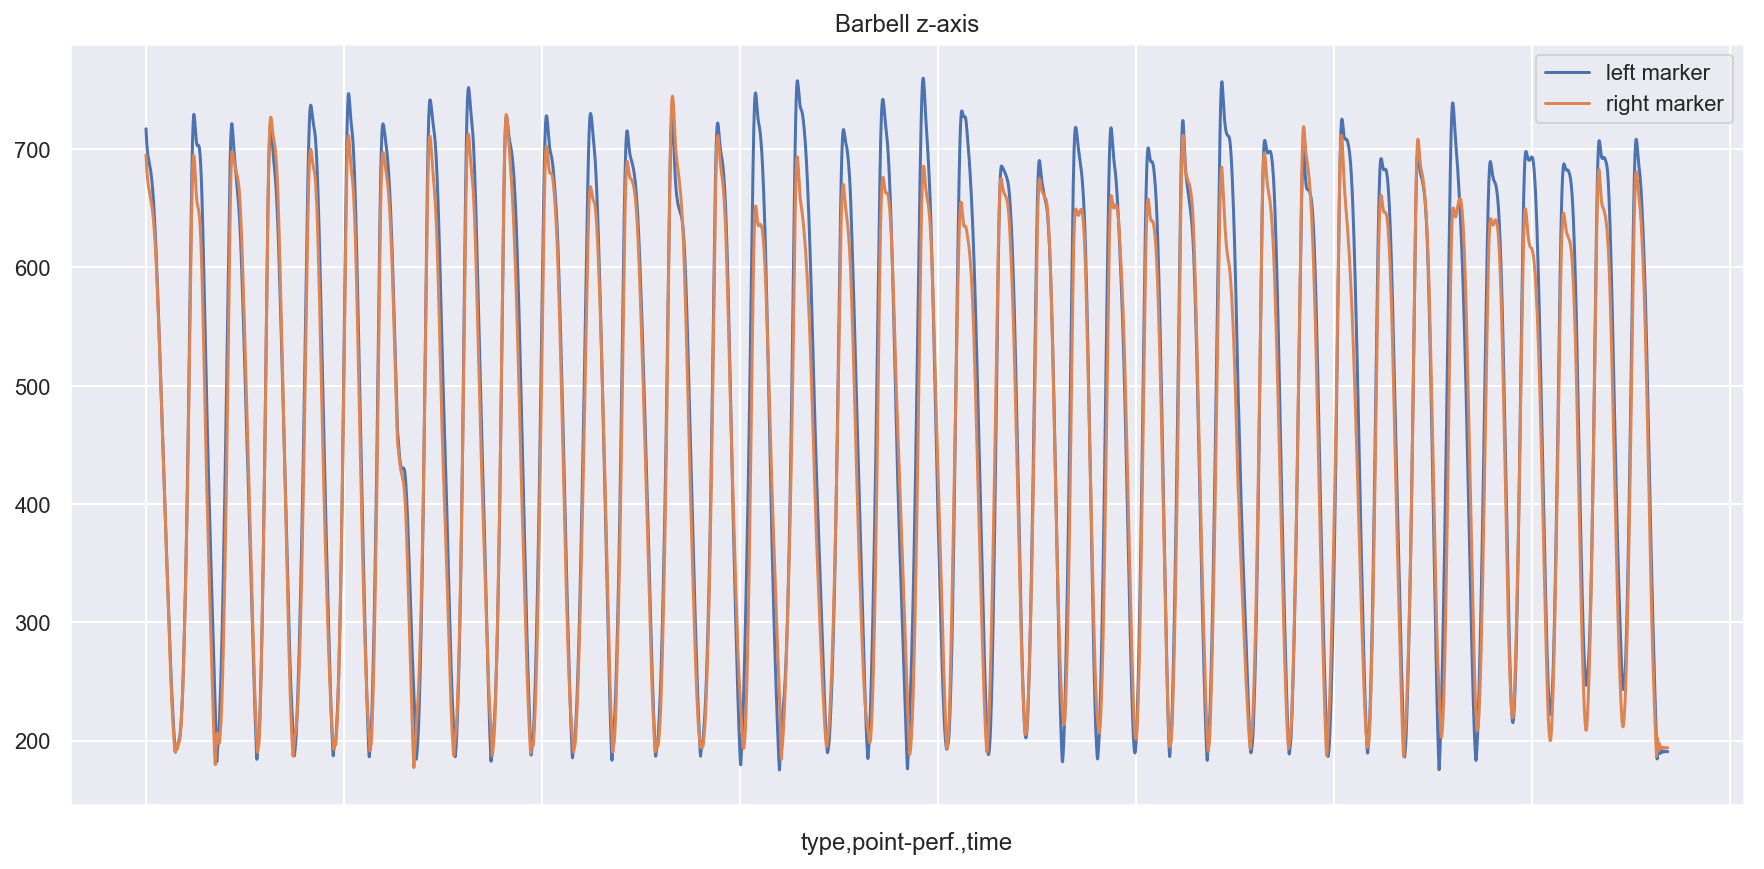

In [7]:

fig, ax = plt.subplots(4,1)
spine_dist_good_df.xs('valerio').iloc[:-10].plot(subplots=True, ax=ax)
ax[0].set_title("Spine marker distances - good repititions - Valerio")
plt.tight_layout()
plt.show()

_, ax = plt.subplots(1, 1)
group_type.get_group('good').xs('valerio')['barbell_left_z'].plot(ax=ax, label="left marker");
group_type.get_group('good').xs('valerio')['barbell_right_z'].plot(ax=ax, label="right marker")
ax.set_title("Barbell markers left and right (z-axis)")
plt.legend();
plt.title("Barbell z-axis");

### Good repititions for Jacob

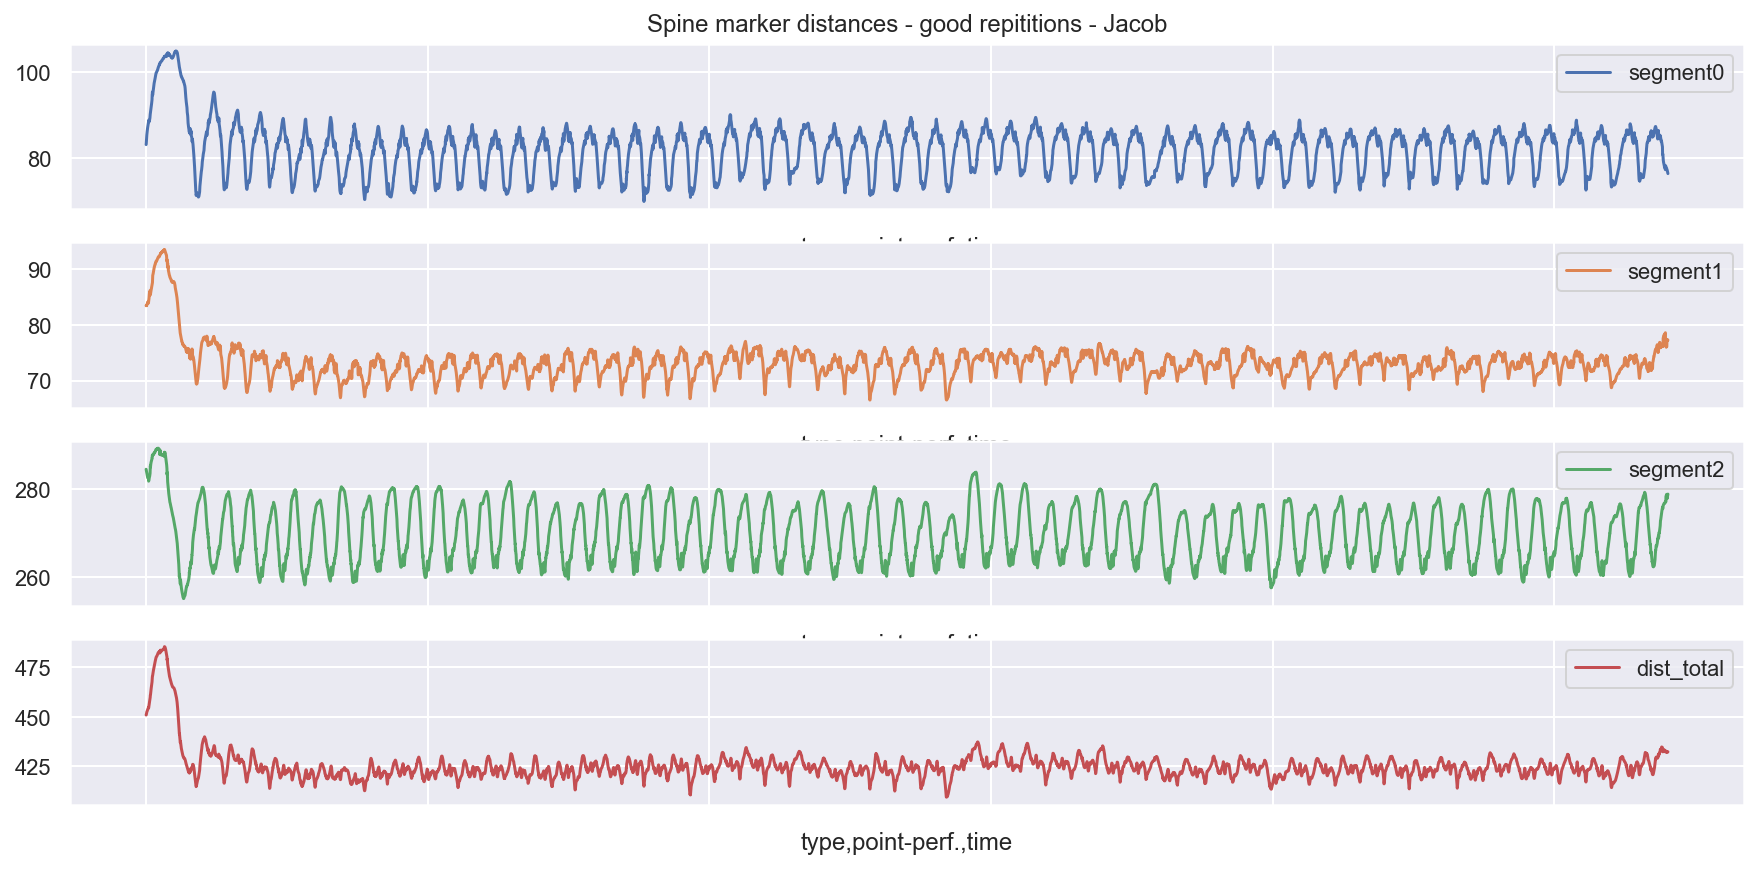

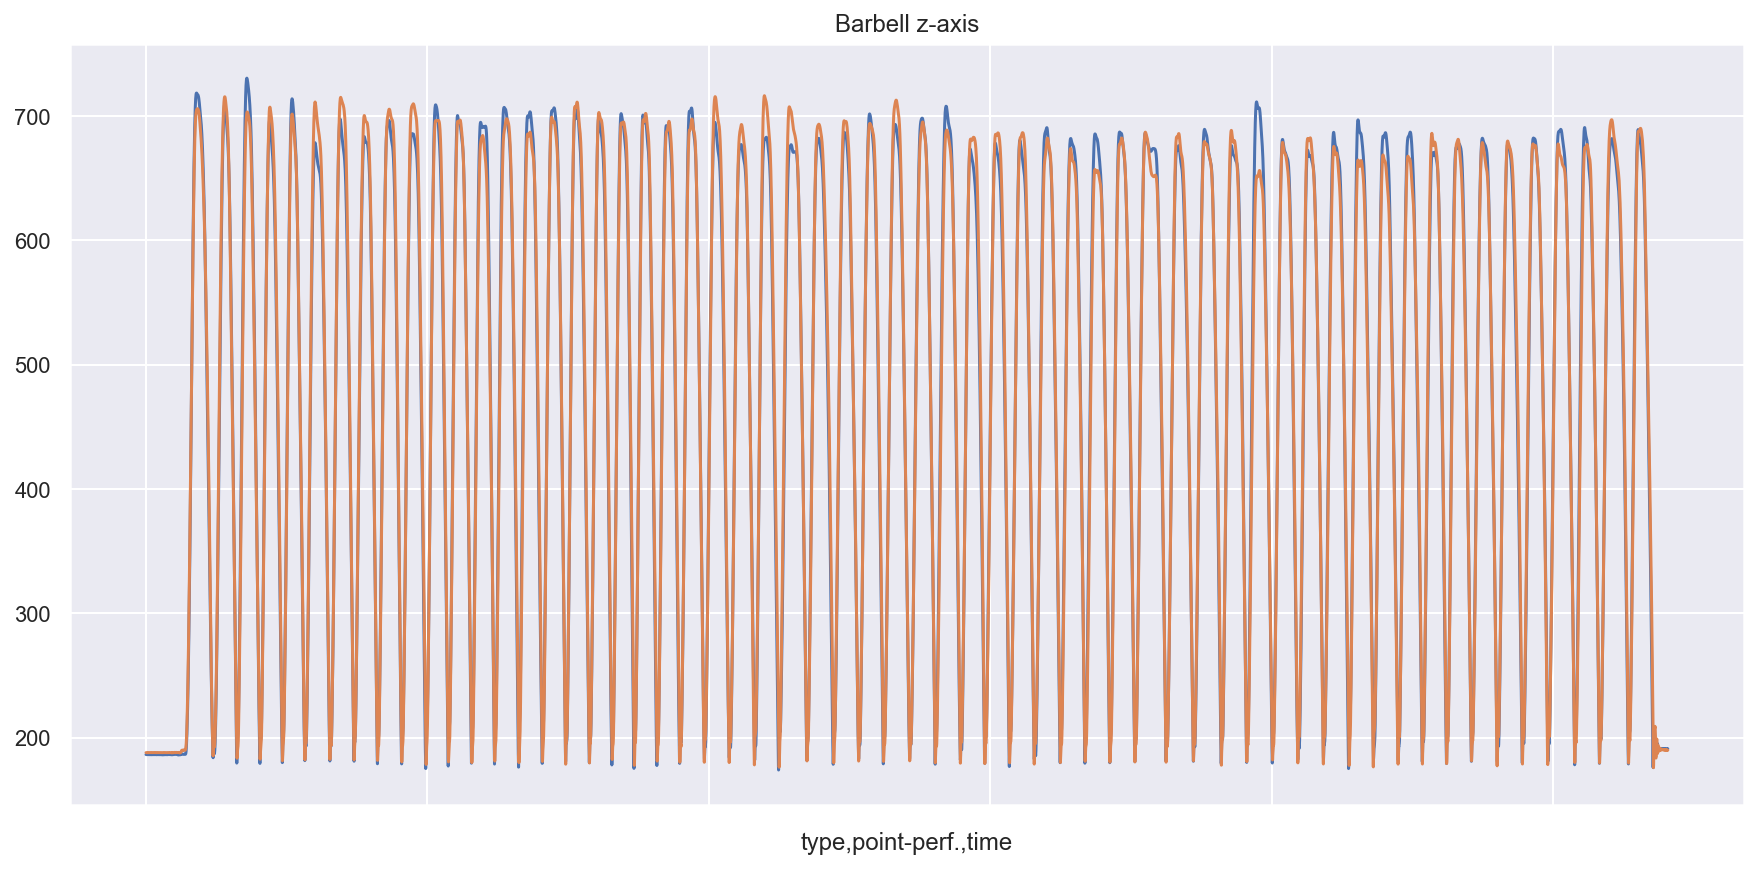

In [8]:
# Look at the good distances for Jacob.
#
fig, ax = plt.subplots(4,1)
spine_dist_good_df.xs('jacob').iloc[:-10].plot(subplots=True, ax=ax)
ax[0].set_title("Spine marker distances - good repititions - Jacob")
plt.show()

group_type.get_group('good').xs('jacob')['barbell_left_z'].plot();
group_type.get_group('good').xs('jacob')['barbell_right_z'].plot();
plt.title("Barbell z-axis");

### Bad repititions for Valerio

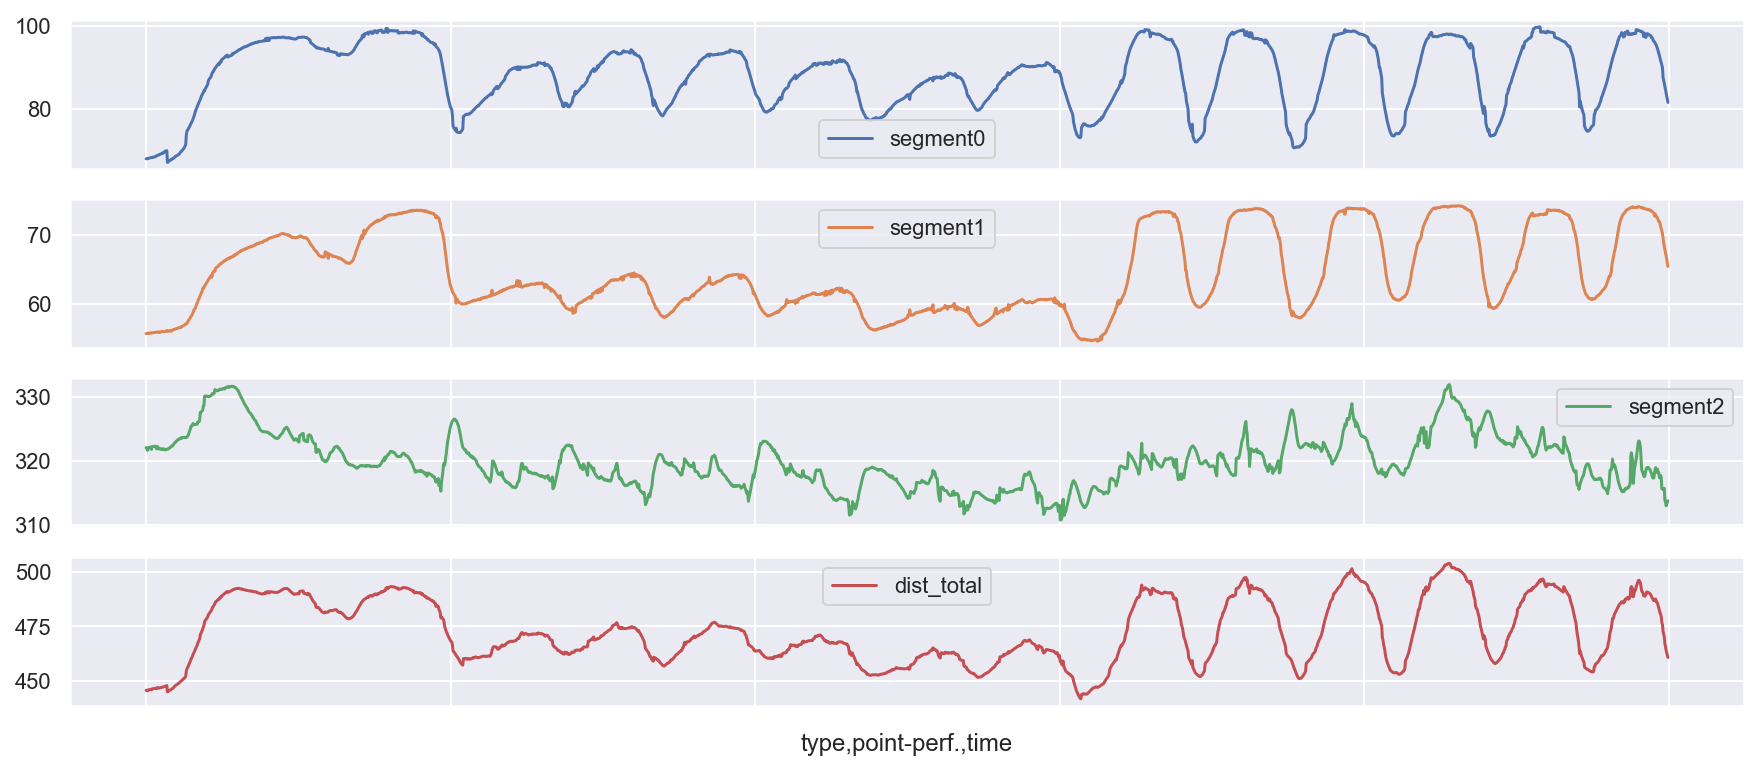

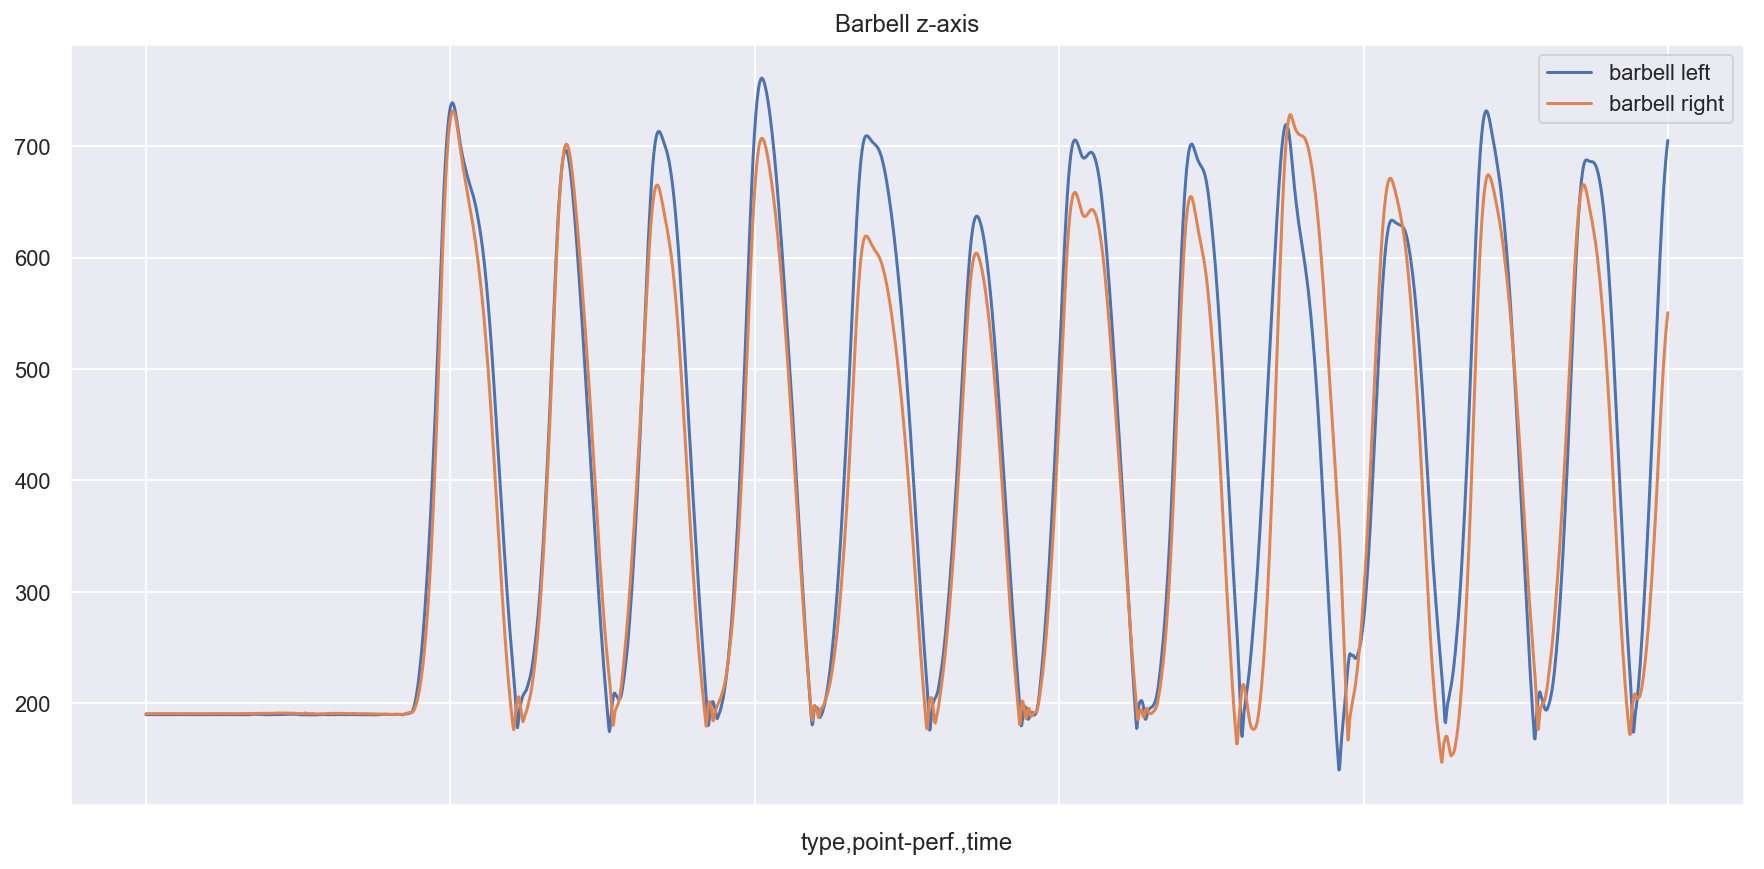

In [9]:
_slice = slice(0,2500)
spine_dist_bad_df.xs('valerio').iloc[_slice].plot(subplots=True);
plt.show()
# plt.tight_layout()
group_type.get_group('bad').xs('valerio')['barbell_left_z'].iloc[_slice].plot(label='barbell left');
group_type.get_group('bad').xs('valerio')['barbell_right_z'].iloc[_slice].plot(label='barbell right');
plt.title("Barbell z-axis");
plt.legend()

### Bad repititions for Jacob

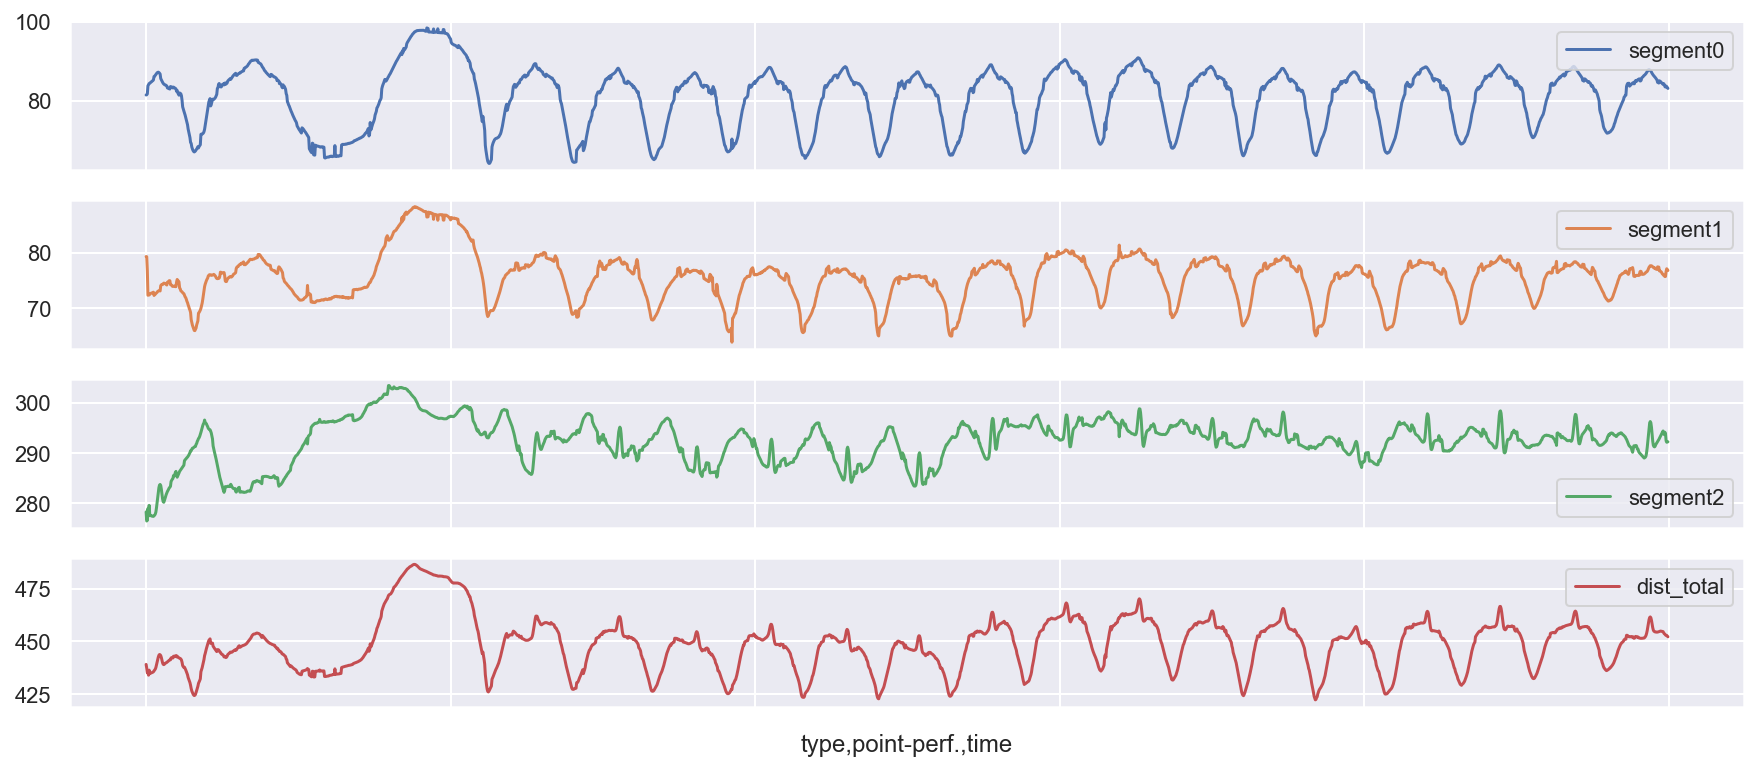

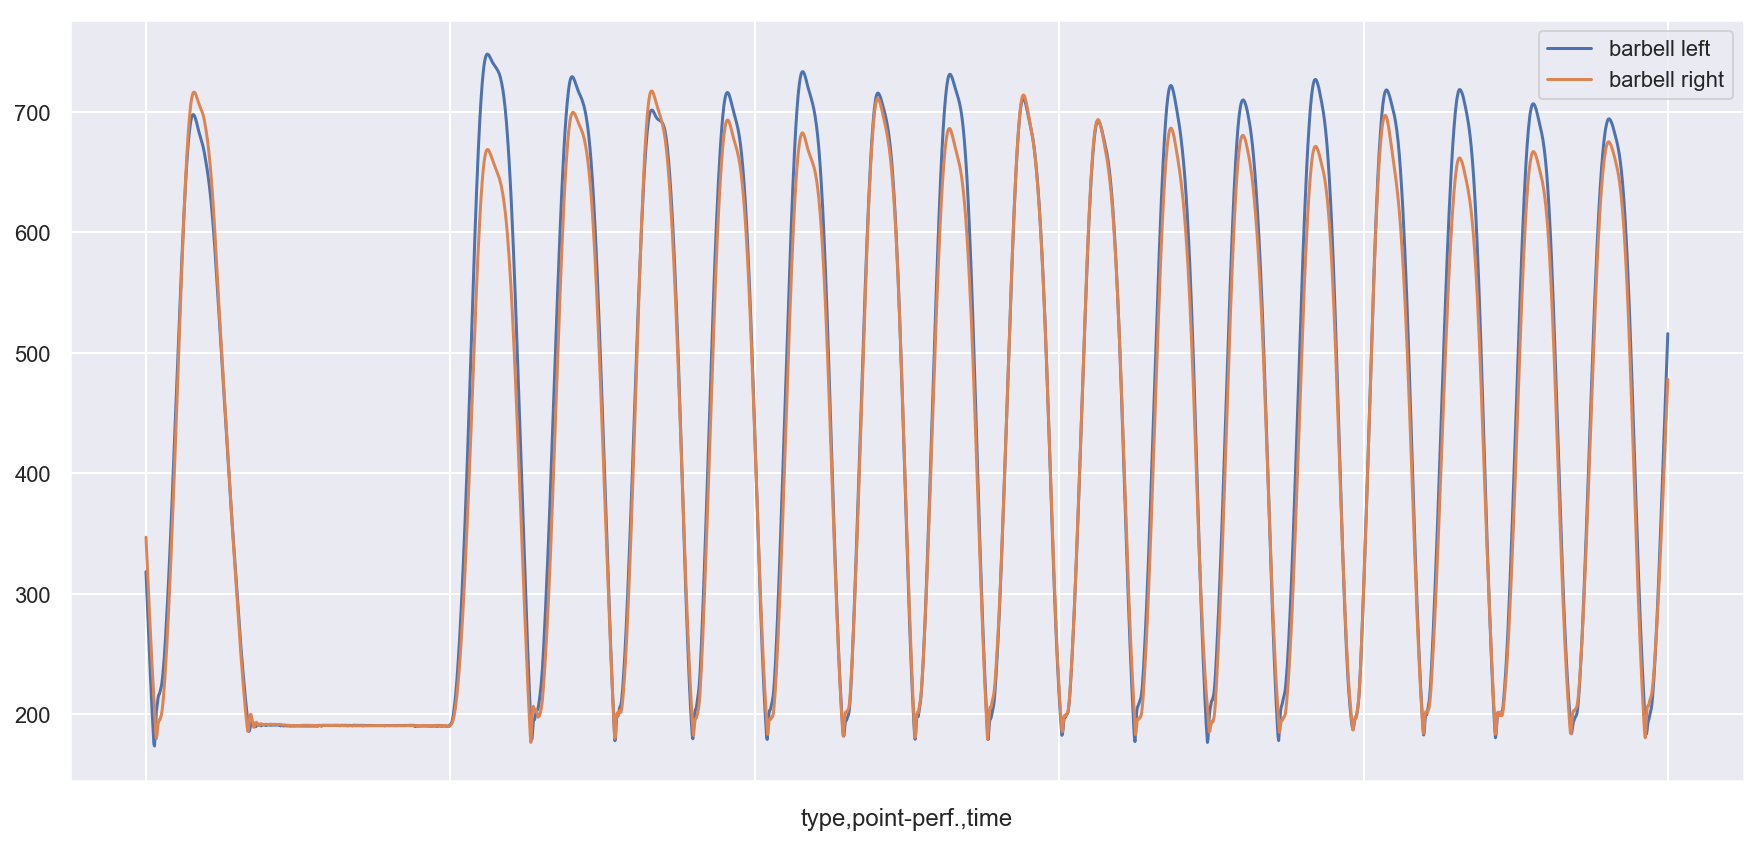

In [10]:
spine_dist_bad_df.xs('jacob').iloc[_slice].plot(subplots=True);
plt.show()

group_type.get_group('bad').xs('jacob')['barbell_left_z'].iloc[_slice].plot(label='barbell left')
group_type.get_group('bad').xs('jacob')['barbell_right_z'].iloc[_slice].plot(label='barbell right')
plt.legend()

### Side-by-side comparison of good and bad repititions for segment lengths of the spine.

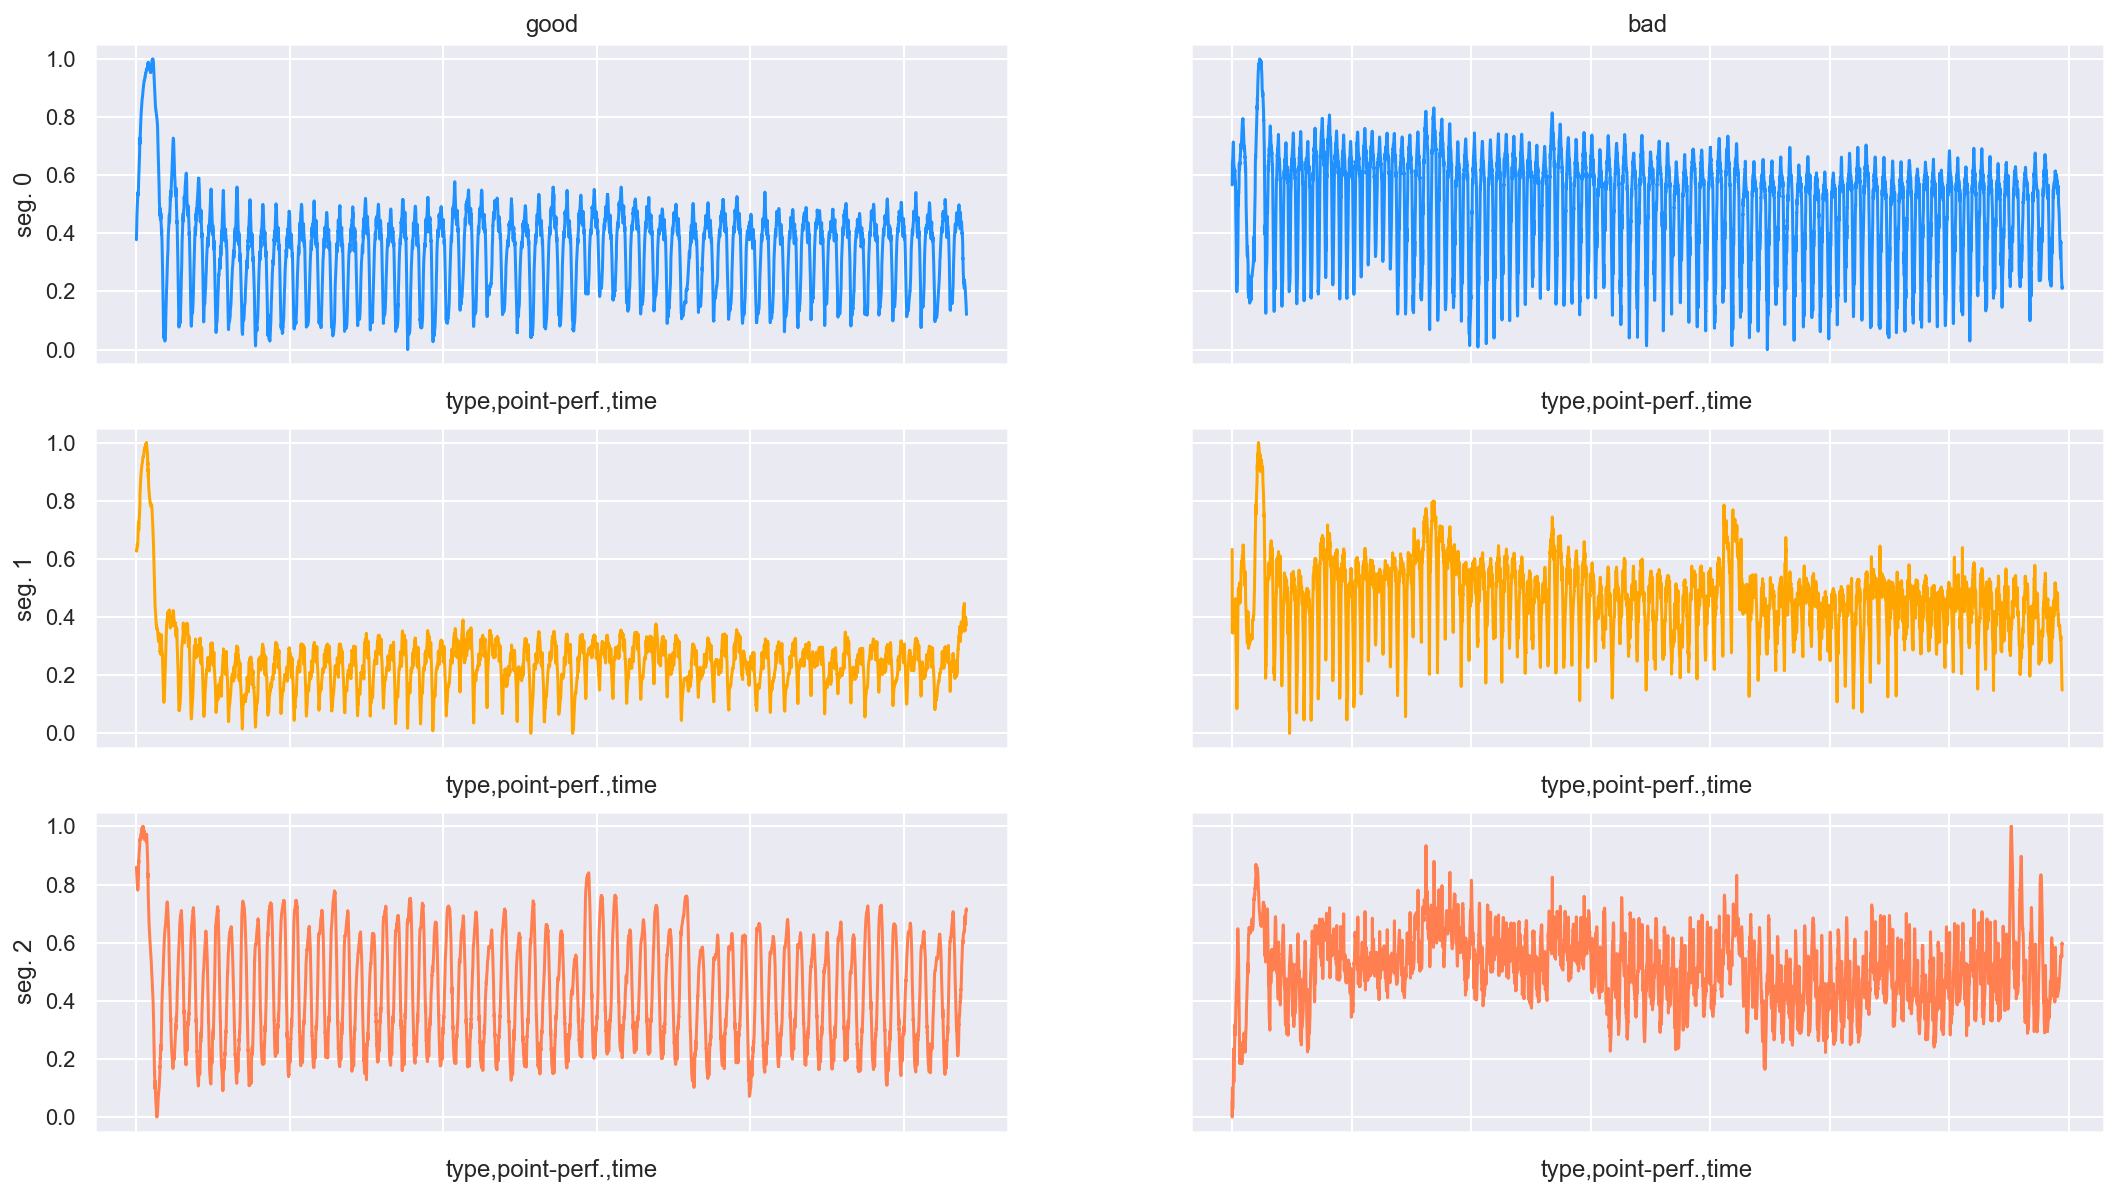

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(18, 10), sharey=True)
ax[0][0].set_title('good');
ax[0][1].set_title('bad');

# segment 0
#
spine_dist_good_df.xs('jacob').apply(data_utils.normalize)['segment0'].plot(ax=ax[0][0], color='dodgerblue')
spine_dist_bad_df.xs('jacob').apply(data_utils.normalize)['segment0'].plot(ax=ax[0][1], color='dodgerblue')
ax[0][0].set_ylabel('seg. 0');

# segment 1
#
spine_dist_good_df.xs('jacob').apply(data_utils.normalize)['segment1'].plot(ax=ax[1][0], color='orange')
spine_dist_bad_df.xs('jacob').apply(data_utils.normalize)['segment1'].plot(ax=ax[1][1], color='orange')
ax[1][0].set_ylabel('seg. 1');

# segment 2
#
spine_dist_good_df.xs('jacob').apply(data_utils.normalize)['segment2'].plot(ax=ax[2][0], color='coral')
spine_dist_bad_df.xs('jacob').apply(data_utils.normalize)['segment2'].plot(ax=ax[2][1], color='coral')
ax[2][0].set_ylabel('seg. 2');



### Locate individual repititions based on the barbell height
Perform various filtering and smoothing operations to the data.

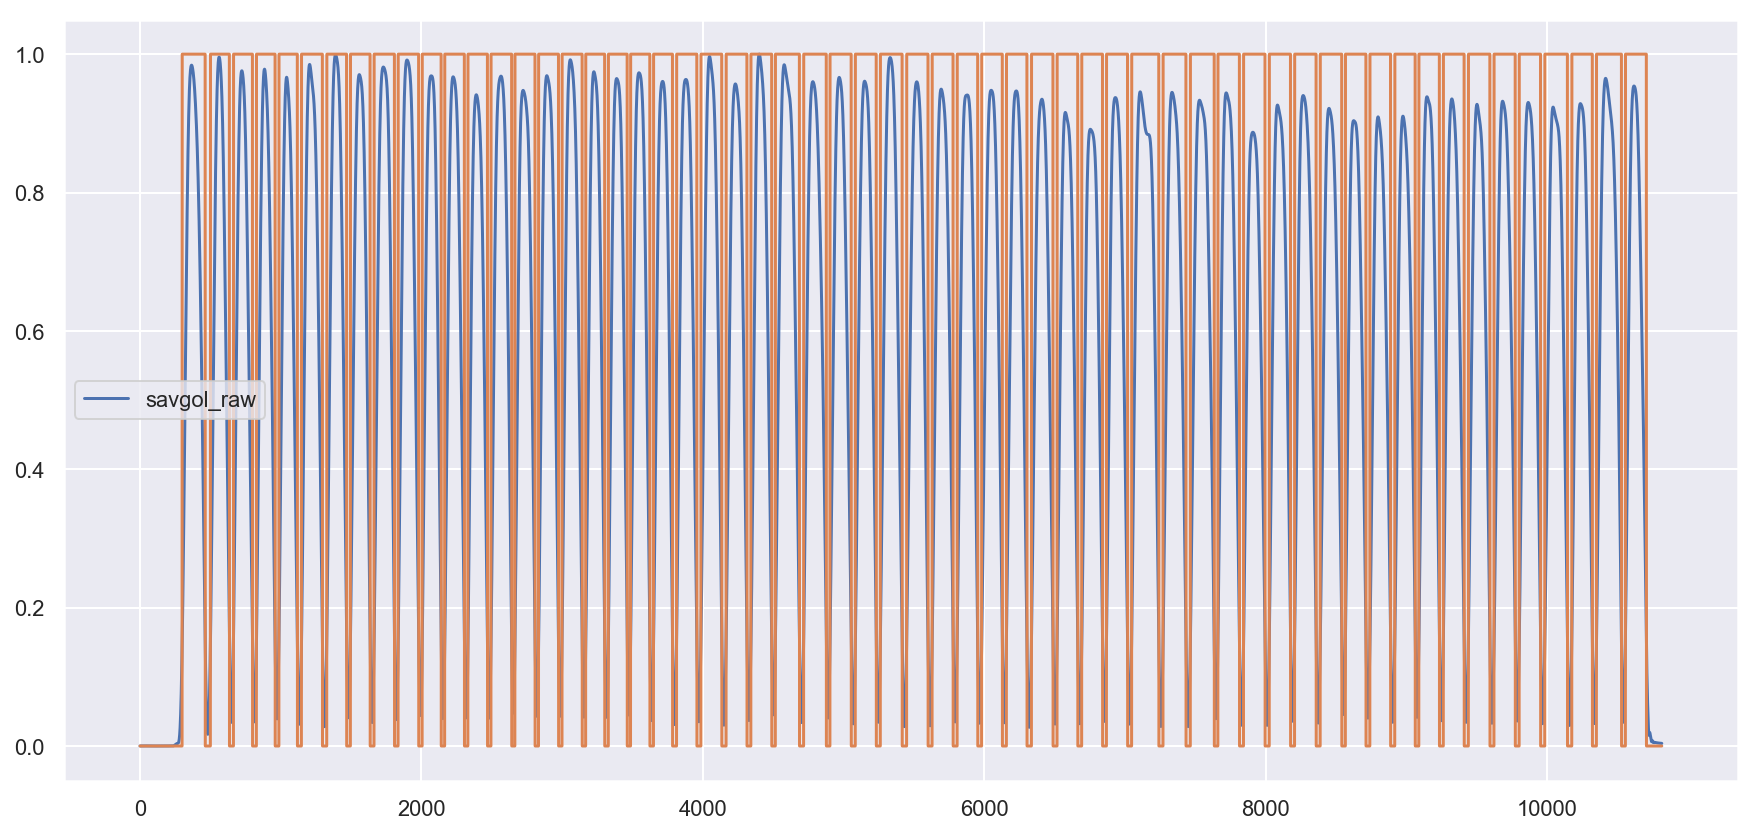

In [23]:


# max_idx = 280
# max_idx = 1000
max_idx = -1

# Get the "raw" data for the barbell path (i.e. no postprocessing)
#
raw = group_type.get_group('good').xs('jacob')['barbell_right_z'][:max_idx].values
raw = data_utils.normalize(raw)
# raw = data_utils.standardize(raw)

# Gradient version of the barbell path.
#
grad = group_type.get_group('good').xs('jacob').apply(data_utils.normalize)['barbell_right_z'][:max_idx].agg('gradient')  
grad = data_utils.normalize(np.gradient(grad))

# Filtered version of the barbell path.
#
filtered = data_utils.butter_lowpass_filter(signal=raw, cutoff=5, fs=100, order=5)
filtered = data_utils.normalize(filtered)


# Smoothed (box car) version of the barbell path.
#
boxcar_raw = data_utils.normalize(data_utils.boxcar_smooth(raw, window=20))

# Smoothed (savgol) version of the barbell path.
#
savgol_raw = data_utils.normalize(data_utils.savgol_smooth(raw, window=25, order=1))

# Filtered (low-pass) and smoothed (savgol) version of the barbell path.
#
savgol_filtered = data_utils.savgol_smooth(filtered, window=11, order=1)

# plt.plot(raw, label='raw')
# plt.plot(grad, label='gradient')
# plt.plot(filtered, label='filtered')
# plt.plot(boxcar_raw, label='boxcar_raw')
plt.plot(savgol_raw, label='savgol_raw')
# plt.plot(savgol_filtered, label='savgol_filtered')

# env = np.abs(hilbert(savgol_raw))
# env = np.abs(hilbert(grad))
env = np.abs(hilbert(raw))
# env = (hilbert(filtered))
# env = (hilbert(savgol_raw))
# env = (hilbert(boxcar_raw))
# square = (filtered > 0.10)
square_pulse = (savgol_raw > 0.15)
# square_pulse = (raw > 0.20)
plt.plot(square_pulse)
# square = (raw < 0.0)
# plt.plot(-1*square)
# plt.plot(env)
plt.legend()

### Find the peaks and valleys in the barbell path.
A peak represents the top of the movement (i.e. barbell is at a maximum height), and a valley (aka trough) represents
the lowest point of the barbell (should be the floor if performed correctly).

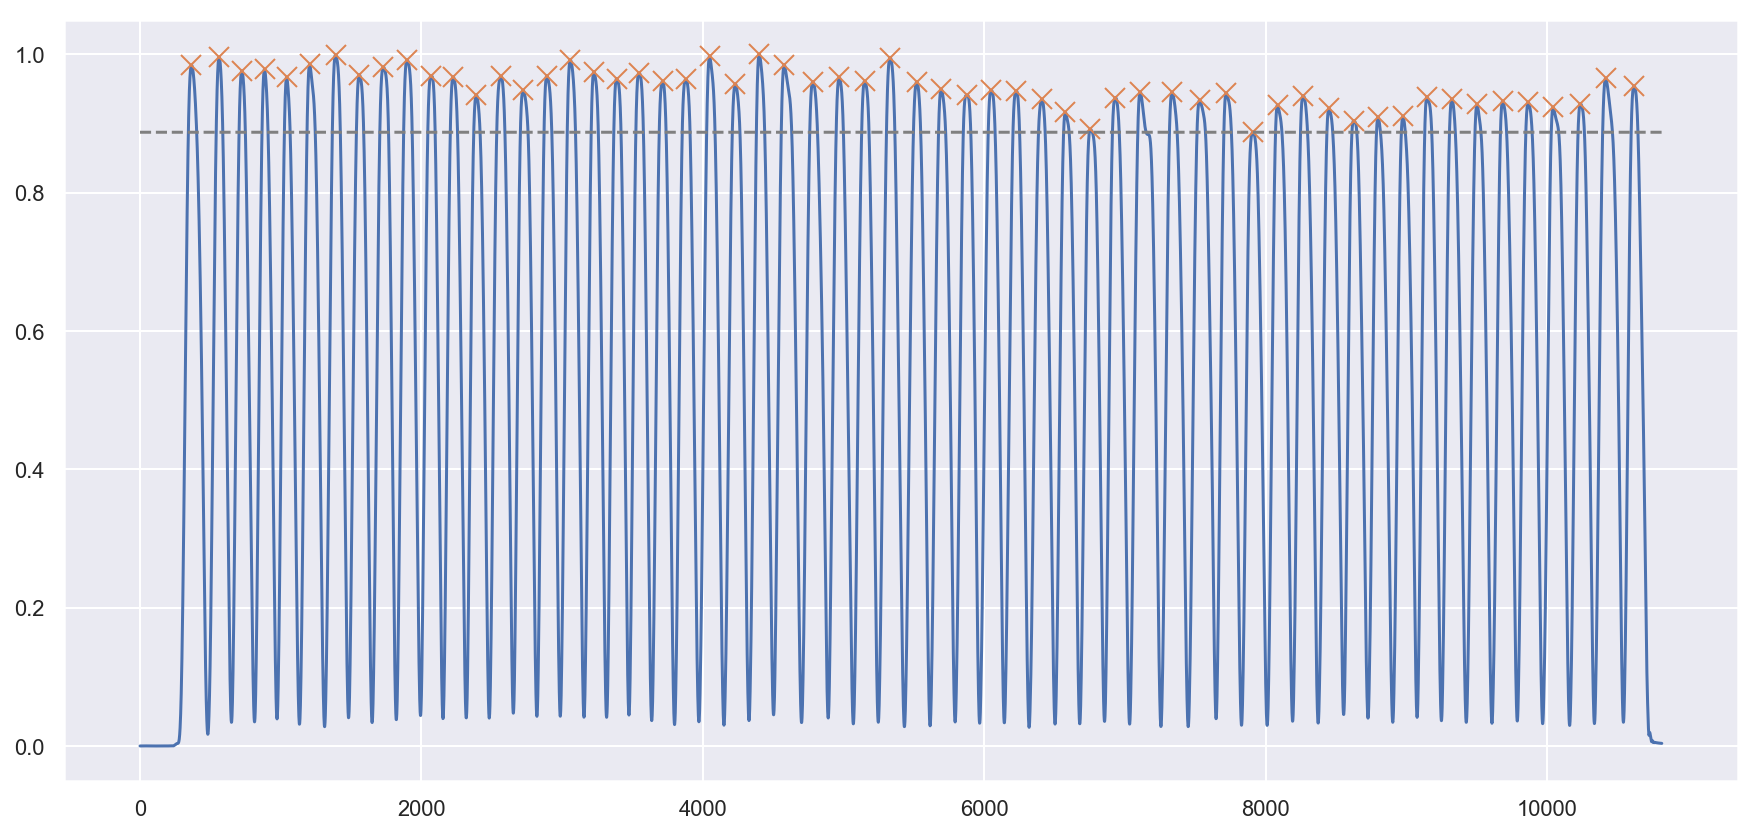

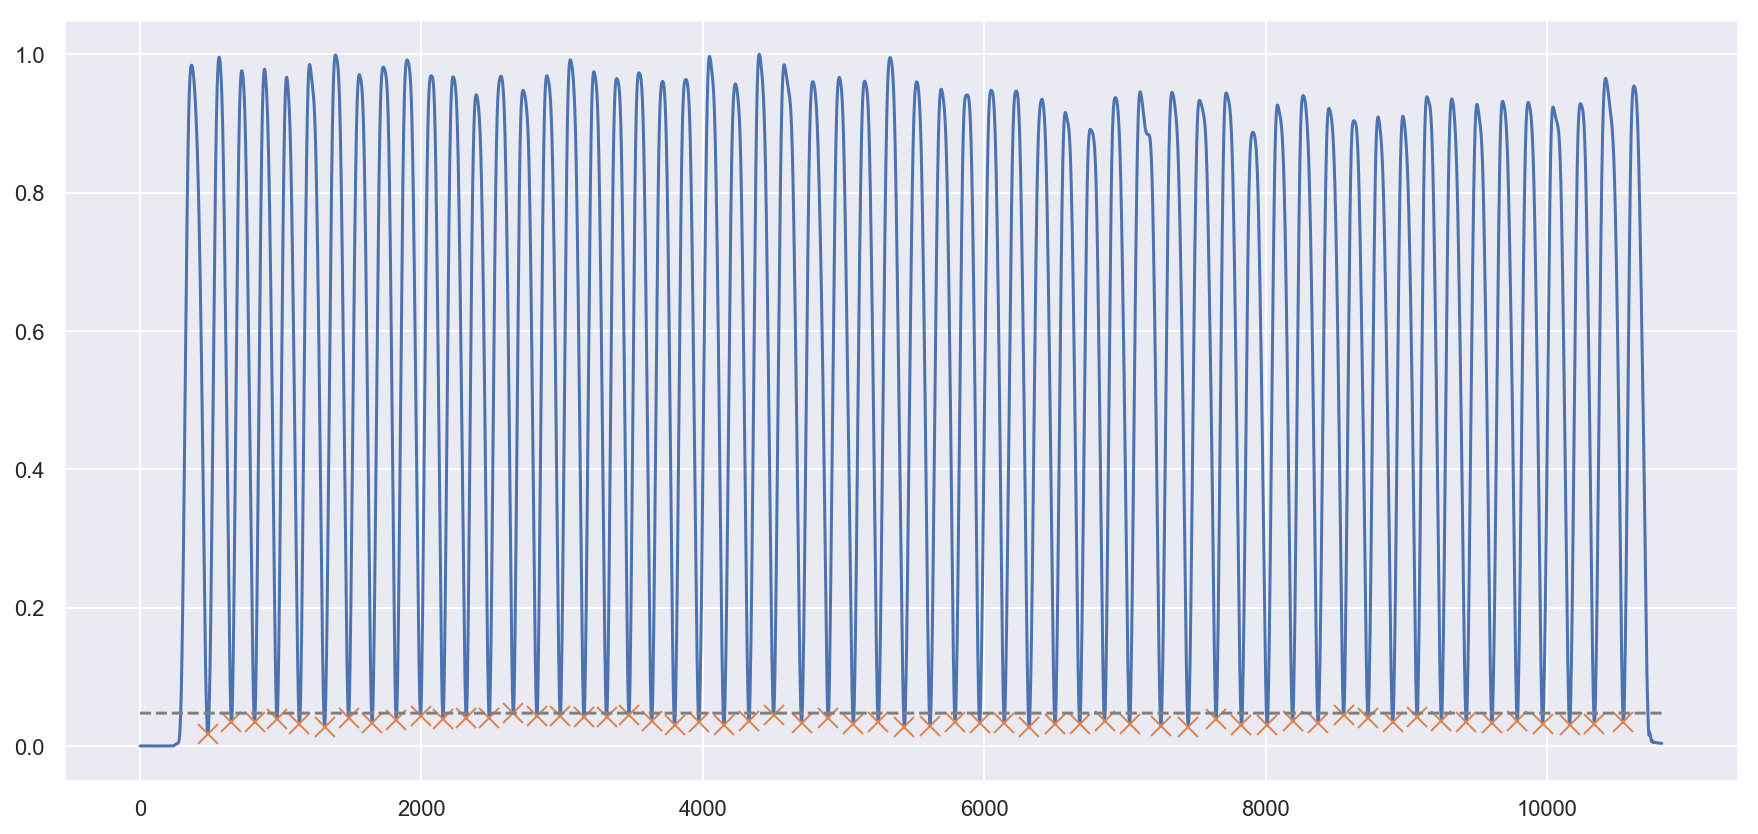

In [24]:

# Use the smoothed version of the barbell path to find peaks and valleys.
#
x = savgol_raw


height=0
peaks, _ = find_peaks(x, height=(0, height+1.1), prominence=0.2)
height = np.min(x[peaks])
plt.plot(x)
plt.plot(peaks, x[peaks], "x", markersize=10)
plt.plot(np.ones_like(x)*height, "--", color="gray")
plt.show()


troughs, _ = find_peaks(-1*x, height=(-1, -0.0), prominence=0.2)
raw_troughs, _ = find_peaks(-1*raw, height=(-1, -0.0), prominence=0.2)
height = np.max(x[troughs])
plt.plot(x)
plt.plot(troughs, x[troughs], "x", markersize=10)
plt.plot(np.ones_like(x)*height, "--", color="gray")
# plt.plot(raw)
plt.show()

### Demonstrate removing portions of the repitition based on barbell height.
Here we remove all data that is below the largest valley, which means we remove all data that goes beyond the participants highest finishing point. This allows us to compare data in the spine that is only based on what was happening with the barbell within a specific range of motion (in this case the highest height of all finishing positions of the rep, to the top of the lift). For instance we could extend this to only look what is happening with the spine with the barbell between the knee and the hip by using the barbell height with respect to the knee and hip markers.

Removing:  0.04748917775978369


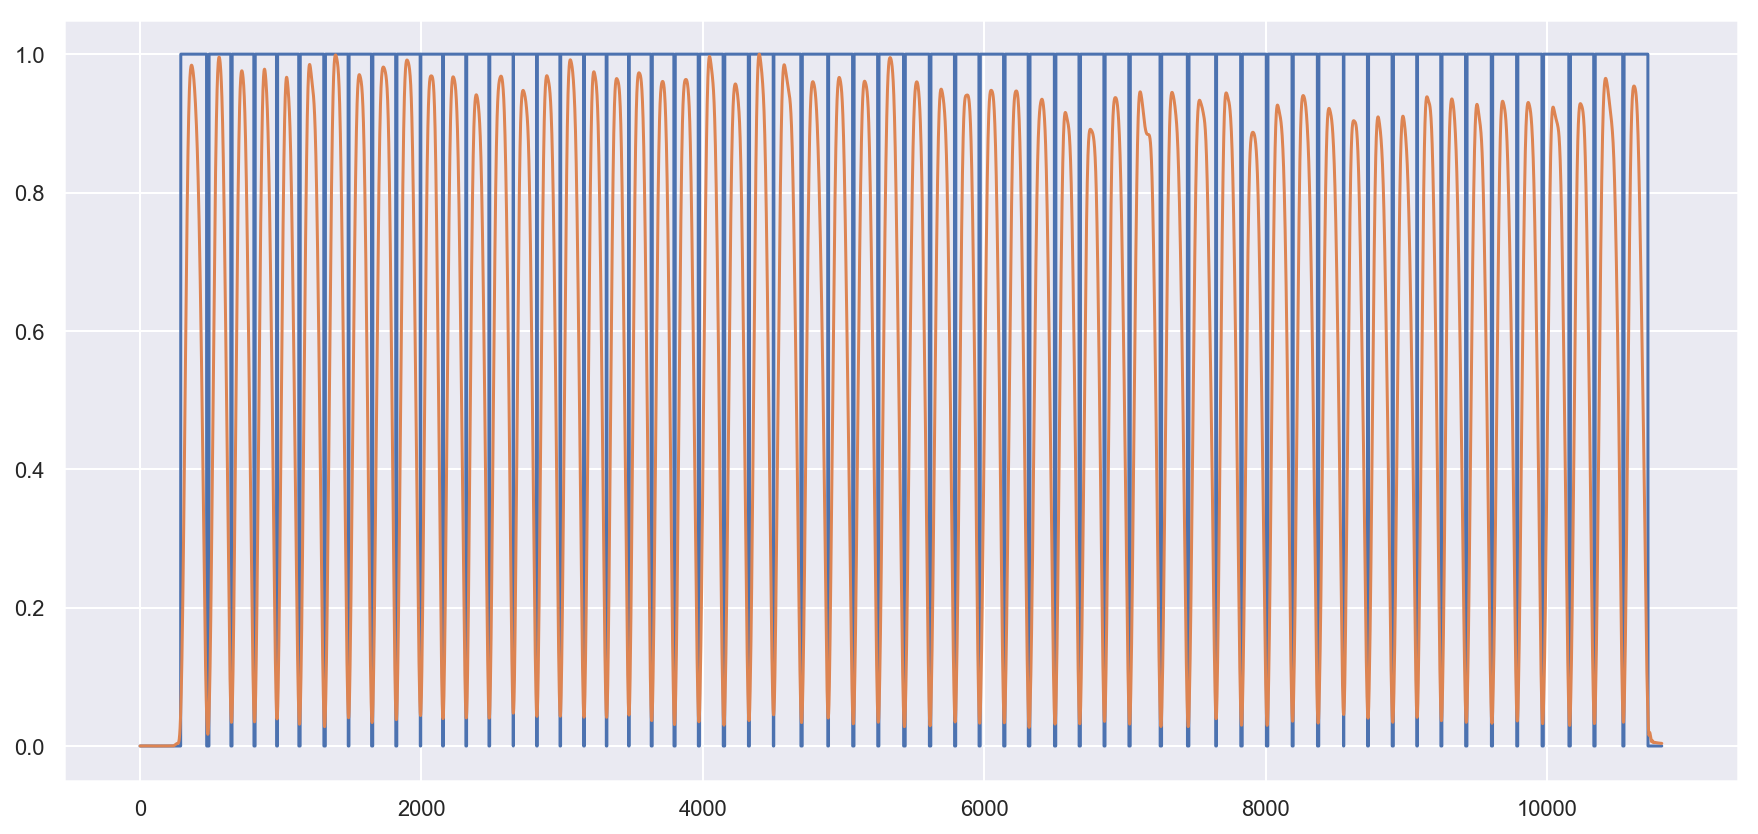

In [25]:
print("Removing: ", np.max(x[troughs]))
square_pulse = (x > np.max(x[troughs]))
# square = (x > 0.01)
plt.plot(square_pulse);
plt.plot(x);

11.17771370266057
6.18723381574615
12.58775909046686


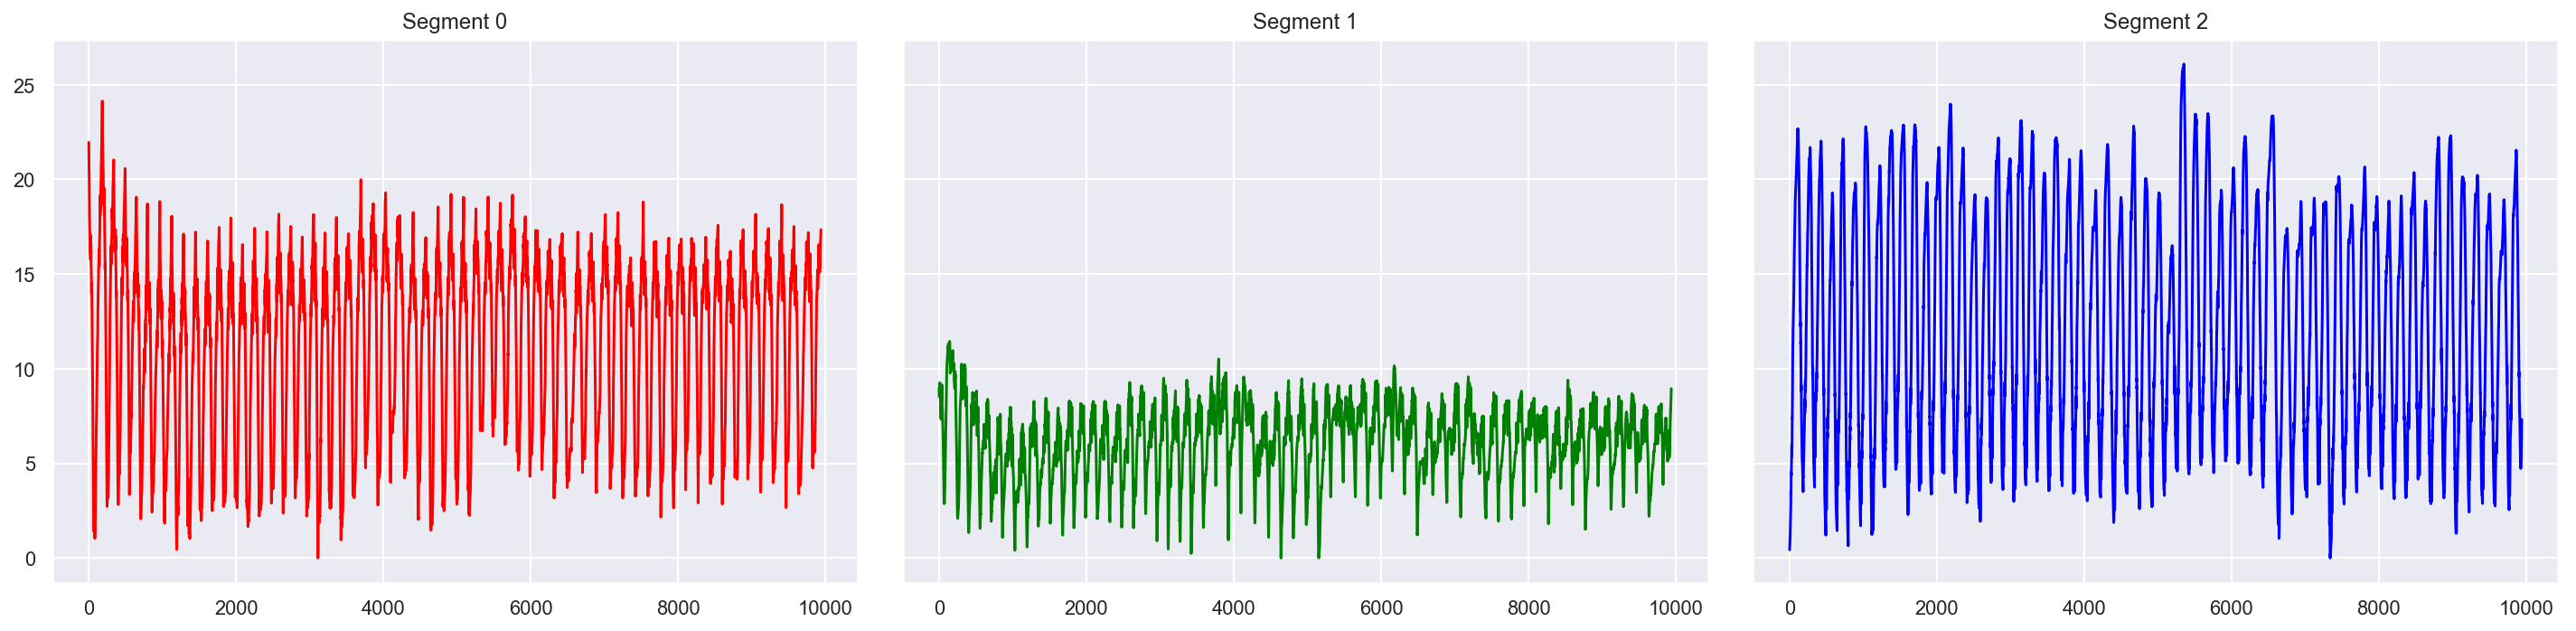

In [26]:
rep_idx = np.argwhere(square_pulse == 1)
# plt.plot(x[rep_idx], alpha=0.5)

# valid_reps_seg0 = normalize(spine_dist_good_df.xs('jacob')['dist_s0_s1'].iloc[rep_idx.ravel()].values)
# plt.plot(valid_reps_seg0)

valid_reps_seg0 = spine_dist_good_df.xs('jacob')['segment0'].iloc[rep_idx.ravel()].values
valid_reps_seg1 = spine_dist_good_df.xs('jacob')['segment1'].iloc[rep_idx.ravel()].values
valid_reps_seg2 = spine_dist_good_df.xs('jacob')['segment2'].iloc[rep_idx.ravel()].values

# Rescale to a minimum value of zero.
#
valid_reps_seg0 = valid_reps_seg0 - np.min(valid_reps_seg0)
valid_reps_seg1 = valid_reps_seg1 - np.min(valid_reps_seg1)
valid_reps_seg2 = valid_reps_seg2 - np.min(valid_reps_seg2)

_, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True, sharex=True)
ax[0].plot(valid_reps_seg0, color='red')
ax[0].set_title("Segment 0")
ax[1].plot(valid_reps_seg1, color='green')
ax[1].set_title("Segment 1")
ax[2].plot(valid_reps_seg2, color='blue')
ax[2].set_title("Segment 2")
plt.tight_layout()

print(np.mean(valid_reps_seg0))
print(np.mean(valid_reps_seg1))
print(np.mean(valid_reps_seg2))

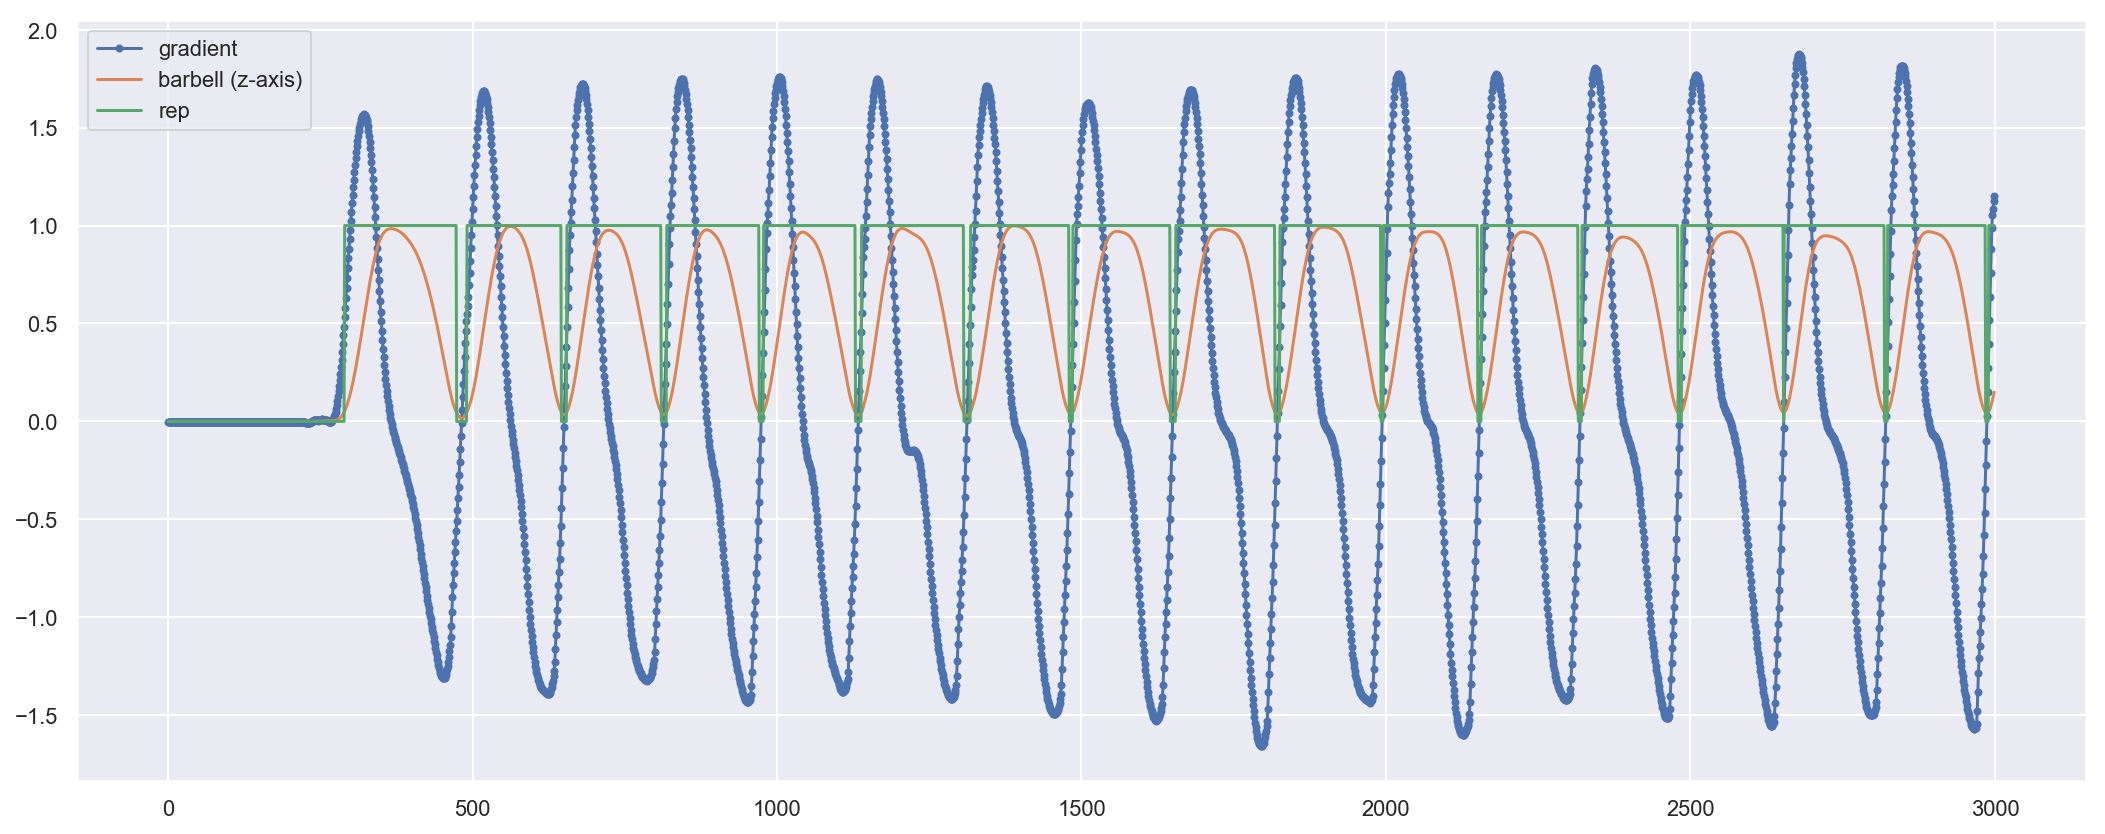

In [27]:
# Find the zero crossings of the gradient in the barbell path.
# The odd zero's are the finish (or beginning) of the rep (i.e. barbell is on the floor)
# The even zero's are at the maximum of the barbell height (i.e. standing position at the end of the rep)
#
total_slice = slice(0,3000, 1)
plt.figure(figsize=(18,7))
barbell_gradient = data_utils.standardize(np.gradient(x[total_slice]))
plt.plot(barbell_gradient, marker='.', label='gradient')
plt.plot(x[total_slice], label='barbell (z-axis)')
plt.plot(square_pulse[total_slice], label='rep')
plt.legend()

### FIXME:
### - Need to interpolate discrete signal to find zeros accurately.
###
# zero_crossings = np.argwhere((barbell_gradient <= 1e-2) & (barbell_gradient >= -1e-2))
# zero_crossings = zero_crossings.ravel()
# plt.plot(zero_crossings, np.zeros_like(zero_crossings), marker='.', markersize=15, linestyle='')
# print(zero_crossings)



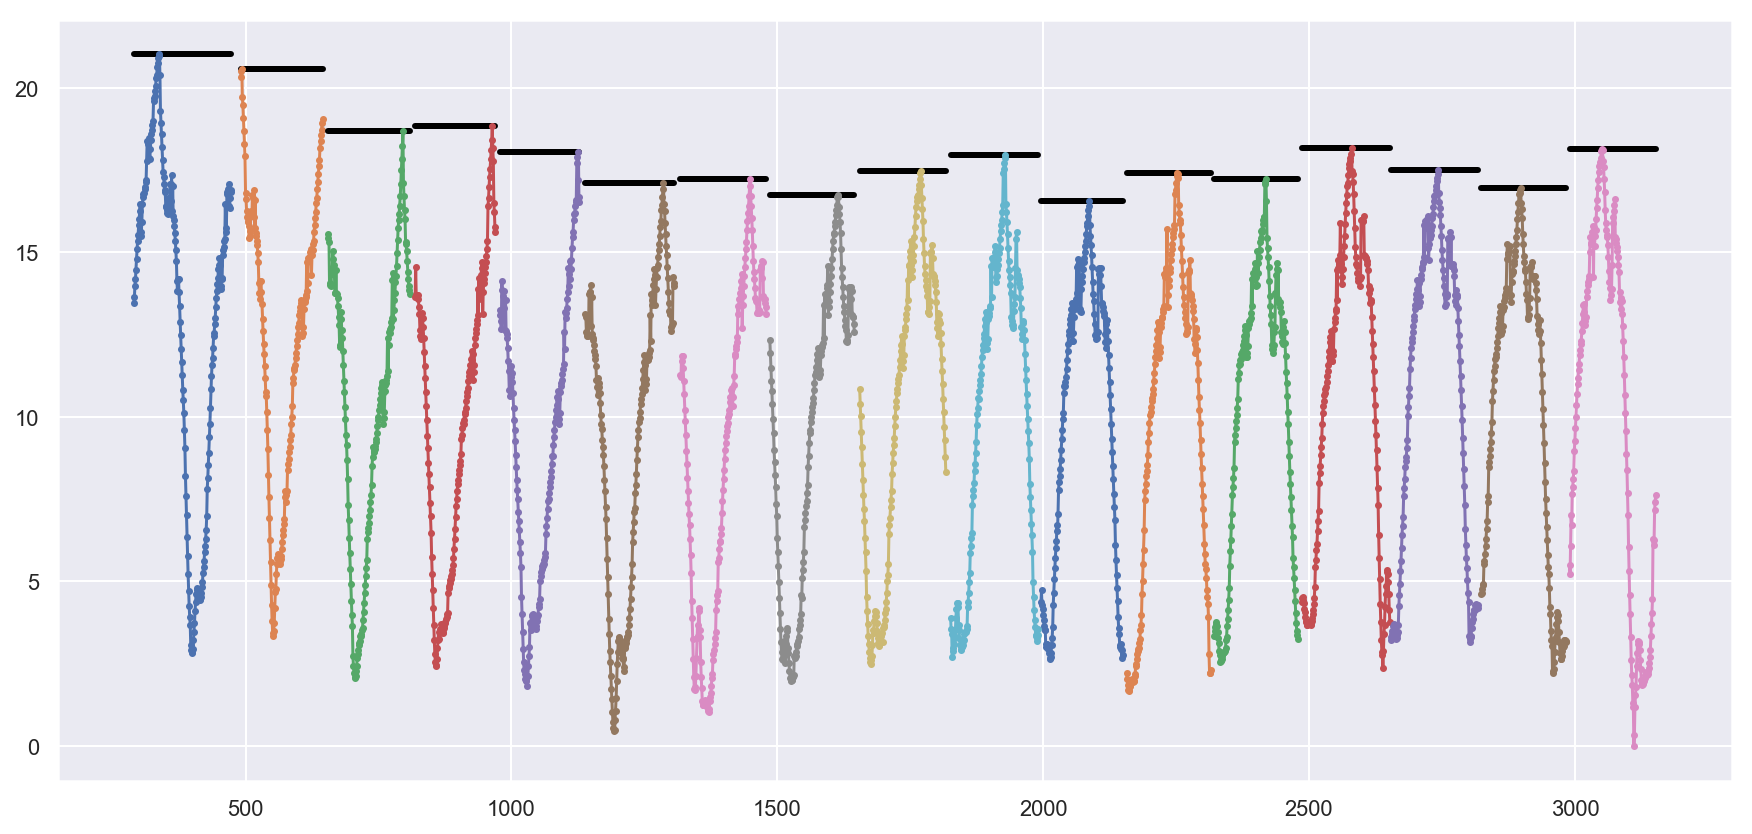

In [28]:
# Extract only the portion of the spine data that pertains to the movement of the barbell.
# ----------------------------- 

idx = -1
rep_cnt = 1
reps_seg0_dict = {}
reps_seg1_dict = {}
reps_seg2_dict = {}

# Loop through the entire square pulse for the barbell movement.
# When the pulse is high, we know there is movement. 
# Otherwise we consider the barbell at rest, and we aren't interested
# in what the spine is doing.
#
while idx < len(square_pulse[:3000])-1:
    # Index into the 'square_pulse' array.
    #
    idx += 1
    
    # Start of a rep (i.e. rising edge)
    #
    if square_pulse[idx] == 1:
        # Note the beginning index when the pulse is high (i.e. barbell is moving).
        #
        start = idx
        
        # Search for the corresponding end of the rep (i.e. falling edge)
        #
        while square_pulse[idx] != 0:
            idx += 1
            
        # Note the end index when we have returned low (i.e. barbell is at rest)
        #
        end = idx
        
        # Grab the chunk of data from the markers that represent a segment on the spine
        # over the start -> end of the rep.
        #
        key = 'rep'+str(rep_cnt)
        reps_seg0_dict[key] = valid_reps_seg0[start:end]
        reps_seg1_dict[key] = valid_reps_seg1[start:end]
        reps_seg2_dict[key] = valid_reps_seg2[start:end]
        
        rep_cnt += 1
        
        # Plot the rep duration found from the square pulse, and the segment
        # distance.
        #
        rep_data = valid_reps_seg0[start:end]
        pulse = np.max(rep_data)*square_pulse[start:end] # Scale the value to sit at the peak.
        plt.plot(range(start, end), pulse, color='black', linewidth=3.0)
        plt.plot(range(start, end), rep_data, marker='.', markersize=5.0)
        
        continue


In [29]:
# Form the dataframes from the dictionaries that hold each individual rep for a given segment.
# ---------------------------------

# Need to form the dataframes below due to each column being different lengths.
#
# reps_seg0_df = pd.DataFrame({k:pd.Series(v) for k, v in reps_seg0_dict.items()})
reps_seg0_df = pd.DataFrame.from_dict(reps_seg0_dict, orient='index').T  # More succinct
reps_seg1_df = pd.DataFrame.from_dict(reps_seg1_dict, orient='index').T
reps_seg2_df = pd.DataFrame.from_dict(reps_seg2_dict, orient='index').T

# Reindex the column names so rep1 --> repN
#
reps_seg0_df = reps_seg0_df.reindex(sorted(reps_seg0_df.columns, key=lambda x: int(x[3:])), axis=1)
reps_seg1_df = reps_seg1_df.reindex(sorted(reps_seg1_df.columns, key=lambda x: int(x[3:])), axis=1)
reps_seg2_df = reps_seg2_df.reindex(sorted(reps_seg2_df.columns, key=lambda x: int(x[3:])), axis=1)



{'bandwidth': 1.0}
{'bandwidth': 0.6693877551020408}
{'bandwidth': 0.7979591836734694}


Text(0.5,1,'Distribution of segment means for good reps')

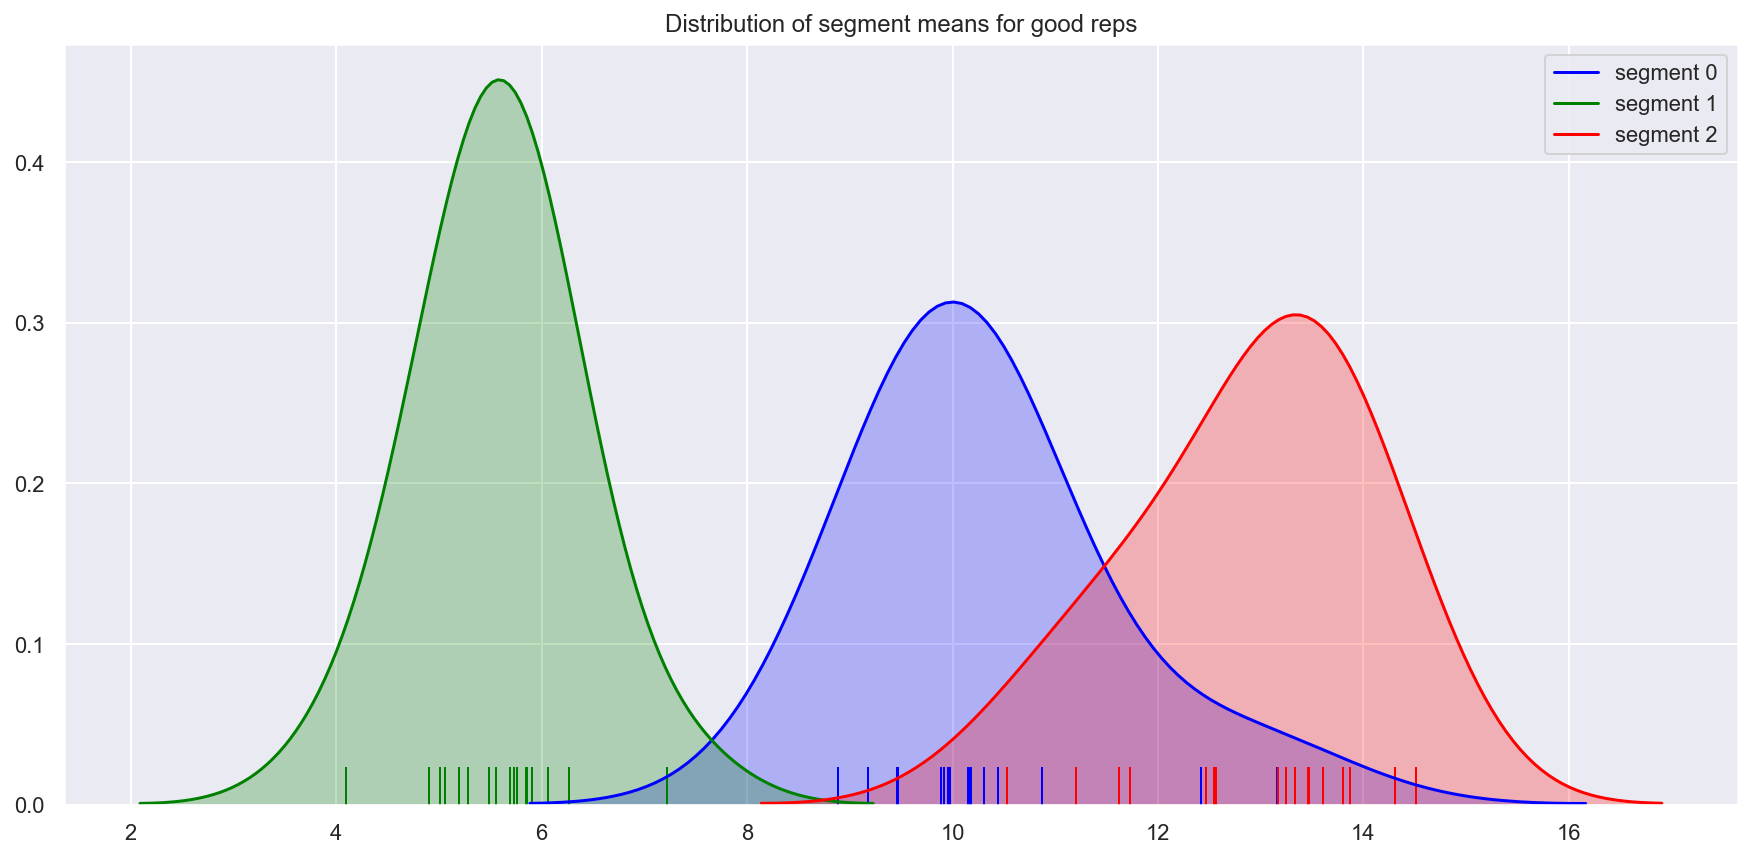

In [31]:
# Find the optimal bandwidth of the kernel density estimation of the underlying data.
# Use cross-validation score (i.e. maximum likelihood) to find the optimal bandwidth
# parameter.
#
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# 15-fold cross-validation
k_folds = 15
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1, 1.0, 50)}, cv=k_folds)

grid.fit(reps_seg0_df.mean().values.reshape(-1, 1))
seg0_bw = grid.best_params_['bandwidth']
print(grid.best_params_)

grid.fit(reps_seg1_df.mean().values.reshape(-1, 1))
seg1_bw = grid.best_params_['bandwidth']
print(grid.best_params_)

grid.fit(reps_seg2_df.mean().values.reshape(-1, 1))
seg2_bw = grid.best_params_['bandwidth']
print(grid.best_params_)


sns.kdeplot(reps_seg0_df.mean(), bw=seg0_bw, shade=True, color='blue', label='segment 0');
sns.rugplot(reps_seg0_df.mean(), color='blue');
sns.kdeplot(reps_seg1_df.mean(), bw=seg1_bw, shade=True, color='green', label='segment 1');
sns.rugplot(reps_seg1_df.mean(), color='green');
sns.kdeplot(reps_seg2_df.mean(), bw=seg2_bw, shade=True, color='red', label='segment 2');
sns.rugplot(reps_seg2_df.mean(), color='red');
plt.title("Distribution of segment means for good reps")

# sns.distplot(reps_seg0_df.mean(), kde=True, hist=False, rug=True)
# sns.distplot(reps_seg1_df.mean(), kde=False, hist=False, rug=True)
# sns.distplot(reps_seg2_df.mean(), kde=False, hist=False, rug=True)
